# 加上两个用户行为特征

1. lb8157版本基础上
2. 增加复合交易率信息
3. 再次扫描负向特征并且去除



In [190]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
%run ../util/base_frame.py

train_df = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
test_df = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')

fa = BaseFrame(train_df, test_df, 7)

# 1 先处理时序数据

In [191]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from sklearn import preprocessing
from datetime import datetime
le = preprocessing.LabelEncoder()

def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

fa.df['weekday'] = fa.df['context_timestamp'].apply(lambda x: extract_weekday(x))
fa.df['hour'] = fa.df['context_timestamp'].apply(lambda x: extract_hour(x))
print(fa.df.shape)

(496509, 32)


# 2 特征处理

### 重复列特征

In [192]:
%run ../util/time_utils.py
dup_feat = ['item_id', 'user_id']
fa.df = generateColDupByDay(fa.df, dup_feat, list(range(1, 8)), verbose=False)
print(fa.df.shape)

(496509, 46)


### 交易率特征选择

*固定smooth为10*

1. 特征是否独立提升?
2. 平滑是否不会改变正负向?

##### 正向特征

> item_city_id, shop_id, user_gender_id, item_sales_level, item_collected_level, shop_review_num_level

##### 负向特征

> item_price_level,
item_id,item_brand_id,item_pv_level,user_age_level,
user_occupation_id,user_star_level,context_page_id,
shop_review_positive_rate,shop_star_level,
shop_score_service,shop_score_description,day,hour


In [193]:
# 计算前一天的交易率set到下一天，第0天用回自己
%run ../util/trade_info.py

trade_rela = ['item_id', 'item_brand_id', 'shop_id', 'user_id']

generateTradeRateByDate(fa.df, trade_rela, 7, None, verbose=False, glbSmoothing=200, glbMean0=0.05)
print(fa.df.shape)

C:\Anaconda3\lib\site-packages\pandas\core\series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


(496509, 55)


### 复合交易率

In [194]:
%run  ../util/trade_info.py


fa.df['u2i_sz'], fa.df['u2i_sum'], fa.df['u2i_rate'] = getMultiTradeRate(fa.df, ['user_id', 'item_id'])
fa.df['u2shop_sz'], fa.df['u2shop_sum'], fa.df['u2shop_rate'] = getMultiTradeRate(fa.df, ['user_id', 'shop_id'])
fa.df['u2brand_sz'], fa.df['u2brand_sum'], fa.df['u2brand_rate'] = getMultiTradeRate(fa.df, ['user_id', 'item_brand_id'])
print(fa.df.shape)

data before day 0 is setted, with period 7, data size 78268
data before day 1 is setted, with period 7, data size 70931
data before day 2 is setted, with period 7, data size 68387
data before day 3 is setted, with period 7, data size 71199
data before day 4 is setted, with period 7, data size 68318
data before day 5 is setted, with period 7, data size 63614
data before day 6 is setted, with period 7, data size 57421
data before day 7 is setted, with period 7, data size 18371
data before day 0 is setted, with period 7, data size 78268
data before day 1 is setted, with period 7, data size 70931
data before day 2 is setted, with period 7, data size 68387
data before day 3 is setted, with period 7, data size 71199
data before day 4 is setted, with period 7, data size 68318
data before day 5 is setted, with period 7, data size 63614
data before day 6 is setted, with period 7, data size 57421
data before day 7 is setted, with period 7, data size 18371
data before day 0 is setted, with period

### 复合类型拆解

In [195]:
%run ../util/complex_type.py
from sklearn import preprocessing
from datetime import datetime
le = preprocessing.LabelEncoder()
fa.df = process_complex_types_v2(fa.df, get_icl_map(fa.df), get_ipl_map(fa.df))

fa.df['item_category_1'] = le.fit_transform(fa.df.item_category_1)
fa.df['item_category_2'] = le.fit_transform(fa.df.item_category_2)
print(fa.df.shape)

get_icl_map ... 
get_ipl_map ... 
processing predict_category_property ...
processing item_property_list ...
processing item_category_list ...
generating item_category_1, item_category_2 ...
(496509, 73)


In [196]:
%run ../util/complex_type.py

cnt_user_item_review = fa.df[["user_id", "item_id", "instance_id"]].groupby(["user_id", "item_id"])['instance_id'].count().to_dict() 
cnt_user_cate_review = fa.df[["user_id", "item_category_1", "instance_id"]].groupby(["user_id", "item_category_1"])['instance_id'].count().to_dict()  

f1 = set_review_cnt("user_id", "item_id", cnt_user_item_review)
f2 = set_review_cnt("user_id", "item_category_1", cnt_user_cate_review)

tmp = fa.df.sort_values(by="context_timestamp")
tmp["item_review_cnt"] = tmp[["user_id", "item_id"]].apply(f1, axis=1)
tmp["cate_review_cnt"] = tmp[["user_id", "item_category_1"]].apply(f2, axis=1)
fa.df = tmp.sort_index()

print(fa.df.shape)

(496509, 75)


In [197]:
fa.df.columns

Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'date', 'day', 'data_set',
       'weekday', 'hour', 'item_id_dup_gg_1', 'item_id_dup_gg_2',
       'item_id_dup_gg_3', 'item_id_dup_gg_4', 'item_id_dup_gg_5',
       'item_id_dup_gg_6', 'item_id_dup_gg_7', 'user_id_dup_gg_1',
       'user_id_dup_gg_2', 'user_id_dup_gg_3', 'user_id_dup_gg_4',
       'user_id_dup_gg_5', 'user_id_dup_gg_6', 'user_id_dup_gg_7', '_key1',
       'exp_d_item_id', 'cnt_d_item_id', 'exp_d_item

# 3 训练

In [198]:
import xgboost
from sklearn.model_selection import ParameterGrid
#import lightgbm as lgb
%run ../util/base_frame.py


non_feat_columns = ['context_timestamp', 'instance_id', 'is_trade', 'context_id',
                   'item_property_list', 'item_category_list',  'predict_category_property','tmp'
                   ]

params = {
    'n_jobs':[7],
    'max_depth':[5],
    'n_estimators':[91],
    'min_child_weight':[5],
    'gamma':[5]
}

xgb = None

# cnt_d_shop_id 单特征变差，全集变好
neg_feat_columns = ['exp_d_user_id', 'cnt_d_item_id', 'cnt_d_item_brand_id', 
                    'shop_id', 'user_occupation_id', 'item_collected_level', 
                    'user_id_dup_gg_1', 'exp_d_item_brand_id', 'u2i_sz', 
                    'category_sim', 'item_property_richness']



if sum(fa.y_test == -1) == 0:
    # 进入测试阶段
    xgb = xgboost.XGBClassifier(n_jobs=7)
    for g in ParameterGrid(params):
        xgb.set_params(**g)
        print('>', '- '*40, '\n\n> ', g, '\n')
#         fa.fit(xgb, pos_feat_columns, '11', drop=False)
        fa.fit(xgb, non_feat_columns+neg_feat_columns, '11', drop=True)
        # fa.fit(xgb, non_feat_columns+['exp_d_user_id', 'cnt_d_item_brand_id'], '11', drop=True)
else:
    # 进入提交阶段
    xgb = xgboost.XGBClassifier(**{'gamma': 5, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 91, 'n_jobs': 7})
    fa.fit(xgb, non_feat_columns+neg_feat_columns, '13_7093_8091_a8178_b8054', drop=True)

# lb8157 base
# -exp_d_user_id: 8092
# -cnt_d_shop_id: 8100
# -cnt_d_item_id: 8091
# -cnt_d_item_brand_id: 8094
# -shop_id_dup_gg_6: 8096
# -weekday: 8096
# 

    
# 0维特征 8590
# item_price_level: 8467, 21842
# exp_d_user_id: 8794
# day: 8582
# item_review_cnt: 8514
# exp_d_item_id: 8407
# shop_score_delivery: 8553
# exp_d_shop_id: 8379
# user_id_dup_gg_1: 8574
# item_sales_level: 8507
# user_star_level: 8587
# user_id_dup_gg_3: 8575

> (478138, 54) 



In [199]:
# 找出每个单特征的logloss
# gg = None
# for g in ParameterGrid(params):
#     gg = g

# guess_feat = [x for x in fa.df.columns if x not in non_feat_columns and x not in ['date', 'date_set']]
    
# xgb = xgboost.XGBClassifier(n_jobs=7)
# xgb.set_params(**g)
# for ft in guess_feat:
    
#     print('- '*40)
#     print(ft)
#     fa.fit(xgb, [ft]+non_feat_columns, '11', drop=True)
    

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
item_id
> (478138, 64) 

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
item_brand_id
model already exists!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
item_city_id
model already exists!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
item_price_level
model already exists!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
item_sales_level
model already exists!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
item_collected_level
model already exists!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
item_pv_level
model already exists!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
user_id
model already exists!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

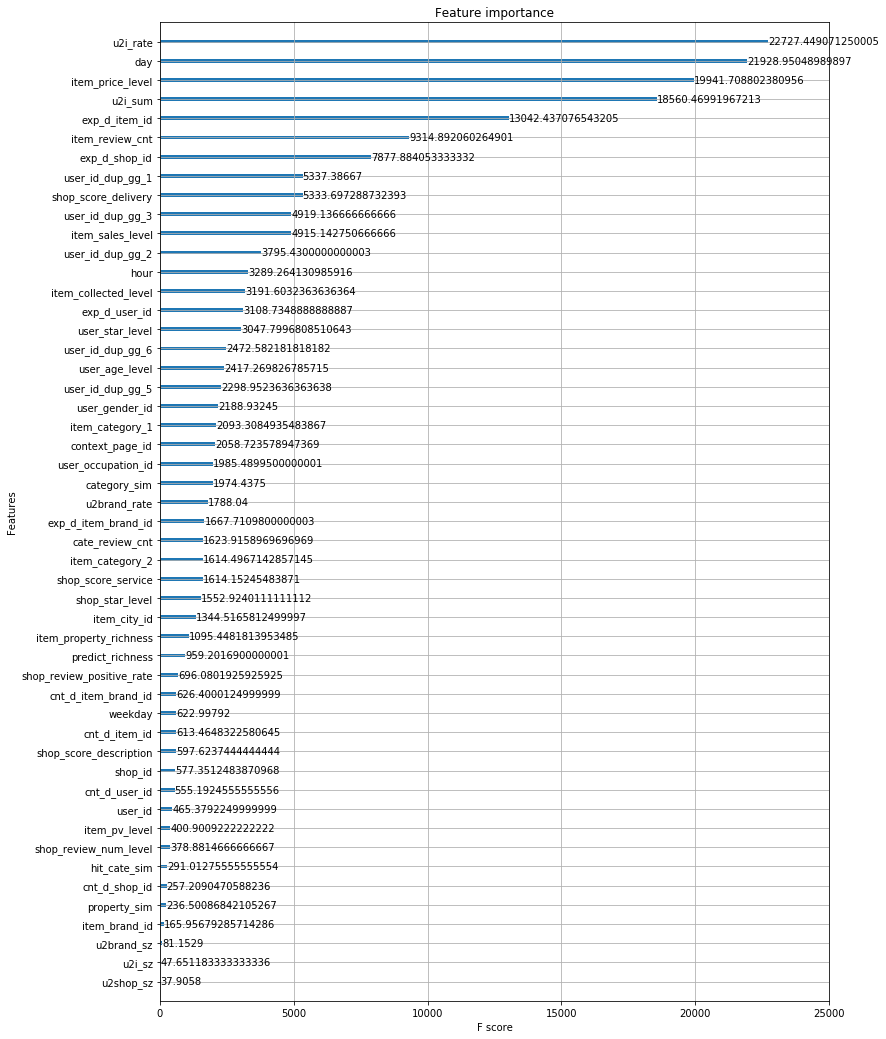

In [200]:
fig,ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb, ax=ax, importance_type='cover')
plt.show()

# 4 超参搜索

In [201]:
from sklearn.model_selection import ParameterGrid
# 训练模型
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import xgboost

params={
    'max_depth': [5],#[6,10,15,20], # 5 is good but takes too long in kaggle env
    'subsample': np.arange(0.9,1,0.1),#[1,0.9,0.8,0.7],#[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.8,0.9],#[0.9]
    'colsample_bytree': [1],#[0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.7,0.75,0.8,0.9,0.95],#[0.9],
    'colsample_bylevel':[1],#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'scale_pos_weight':[1],#[0.7,0.8,1,1.1,1.2],#0.1,0.5,1,2,5
    'max_delta_step':np.arange(0.91,0.99,0.01),#[0,0.1,0.001,0.05,0.005,0.5,1,2],
    'n_estimators': [91],#[100,90,91,92,93,94,95,96,97,98,99],#[200,230,260,270,280,290,300]
    'reg_lambda': np.arange(0.5,1.5,0.1),#[1.3,1.4,1.5,1.6],
    'reg_alpha': [0],#[0,0.01,0.1,0.02,0.2],#[0.01,0.05,0.005,0.2,0.1,0.02,0.0001,0],#
    'min_child_weight':[5],#[7,8,9,10,11,12,13,14,15,16,17,18,19,20],#[23],#[20,21,22,23,24,25,26],#
    'gamma':[6],#[6],#[0.1],#
    'learning_rate':[0.1],#[0.01,0.015,0.02,0.025,0.05,0.005,0.1],#[0.02]#
}

# if sum(y_test == -1) == 0:
#     xgb = xgboost.XGBClassifier(n_jobs=7)
#     best_score = 1 
#     for g in ParameterGrid(params):
#         xgb.set_params(**g)

#         # 分离a,b榜
#         X_val_a, X_val_b, y_val_a, y_val_b = train_test_split(X_test, y_test, test_size=0.7, shuffle=True, random_state=6)
#         m = xgb.fit(X_train, y_train, eval_metric='logloss')

#         val_train_loss = log_loss(y_train, m.predict_proba(X_train))
#         val_test_loss = log_loss(y_test, m.predict_proba(X_test))
#         val_a_loss = log_loss(y_val_a, m.predict_proba(X_val_a))
#         val_b_loss = log_loss(y_val_b, m.predict_proba(X_val_b))
#         print('-'*80)
#         print(g)
#         print('(%s -> %s) train logloss: %.5f, test logloss: %.5f, a: %.5f, b: %.5f' % \
#               (starts, ends, val_train_loss, val_test_loss, val_a_loss, val_b_loss))

#         # save if best
#         if val_test_loss < best_score:
#             best_score = val_test_loss
#             best_grid = g

#     print('-'*80, '\n')        
#     print ("log loss: %0.5f" % best_score )
#     print ("Grid:", best_grid)

In [202]:
from datetime import datetime
print(datetime.now())

2018-04-10 00:47:31.111393
